In [1]:
import torch
from torch import nn

import dgl

import cloudpickle

import matplotlib.pyplot as plt
from ipywidgets import interact

from tqdm import trange
import csv

import numpy as np
import os

In [2]:
plt.rcParams['figure.figsize'] = [5,4]
plt.rcParams['font.size'] = 16
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["axes.formatter.use_mathtext"] = True

In [3]:
d = '20240423183430' #'20240423183430' # 

learning_dir = 'mcmNonParamODE2Dsym_'+d
simulation_dir = 'mcmSimulate_'+d

device = 'cuda:2'

In [4]:
torch.no_grad()

In [5]:
with open(os.path.join(simulation_dir, 'Mcm_SDE_model.pt'), mode='rb') as f:
    simulation_model = cloudpickle.load(f)
print(simulation_model)

print(simulation_model.state_dict())

dynamicGSDEwrapper(
  (dynamicGNDEmodule): dynamicGNDEmodule(
    (calc_module): interactionModule(
      (J_chem): J_chemoattractant2D(
        (k1): torch_kn_cutoff(
          (cutoff_module): ReLU()
        )
      )
      (J_CF): J_contactFollowing()
      (J_CIL): J_contactInhibitionOfLocomotion()
      (A_CFs_module): Embedding(2, 1)
      (A_chems_module): Embedding(2, 1)
      (distanceCalc): euclidDistance_periodic()
    )
    (edgeRefresher): edgeRefresh(
      (edgeConditionModule): radiusgraphEdge(
        (scoreCalcModule): distanceSigmoid()
        (distanceCalc): euclidDistance_periodic()
        (distance2edge): distance2edge_batched()
      )
      (scorePostProcessModule): pAndLogit2KLdiv()
      (scoreIntegrationModule): scoreListModule()
    )
  )
  (ndataInOutModule): multiVariableNdataInOut()
  (derivativeInOutModule): multiVariableNdataInOut()
  (noiseInOutModule): singleVariableNdataInOut()
)
OrderedDict([('dynamicGNDEmodule.calc_module.sigma', tensor(0.4472)), 

In [6]:
with open(os.path.join(learning_dir, 'Mcm_nonParametric2Dsym_learned_model.pt'), mode='rb') as f:
    learned_model = cloudpickle.load(f)
print(learned_model)

print(learned_model.state_dict())

dynamicGSDEwrapper(
  (dynamicGNDEmodule): dynamicGNDEmodule(
    (calc_module): interactionModule_nonParametric_2Dsym(
      (J_chem): J_chemoattractant2D(
        (k1): torch_kn_cutoff(
          (cutoff_module): ReLU()
        )
      )
      (J_CF): J_contactFollowing()
      (J_CIL): J_contactInhibitionOfLocomotion()
      (A_CFs_module): Embedding(2, 1)
      (A_chems_module): Embedding(2, 1)
      (distanceCalc): euclidDistance_periodic()
      (embedding): ModuleList(
        (0): Embedding(2, 2)
        (1): Embedding(2, 2)
        (2): Embedding(2, 2)
        (3): Embedding(2, 2)
      )
      (fNN): Sequential(
        (Linear0): Linear(in_features=7, out_features=128, bias=True)
        (ELU0): ELU(alpha=1.0)
        (Linear1): Linear(in_features=128, out_features=128, bias=True)
        (ELU1): ELU(alpha=1.0)
        (Linear2): Linear(in_features=128, out_features=128, bias=True)
        (ELU2): ELU(alpha=1.0)
        (Linear3): Linear(in_features=128, out_features=2, bias

In [7]:
L = 10

In [8]:
xct = torch.load(os.path.join(simulation_dir, 'Mcm_SDE_traj_celltype.pt'))
x = xct['xtheta']
ct = xct['celltype']
print(x)
print(ct)

tensor([[[[8.4990e+00, 1.0847e+01, 1.3675e+00],
          [4.1242e+00, 1.7961e+01, 4.9782e+00],
          [8.1051e+00, 1.9206e+01, 5.3787e+00],
          ...,
          [7.4452e+00, 1.4361e+01, 4.6169e+00],
          [1.7798e+01, 1.4490e+01, 3.4111e-01],
          [1.2169e+01, 9.7937e+00, 3.9123e+00]],

         [[5.0884e+00, 1.0393e+01, 2.6490e+00],
          [1.4460e+00, 4.0202e+00, 5.1108e+00],
          [1.7414e+01, 1.7085e+01, 4.3650e+00],
          ...,
          [1.1394e+01, 9.0630e+00, 5.8473e+00],
          [1.2688e+01, 1.8612e+01, 2.1958e+00],
          [1.0724e+01, 1.8870e+00, 3.3452e+00]],

         [[1.2349e+01, 9.0202e+00, 2.7716e+00],
          [7.0120e+00, 4.7698e+00, 5.3056e+00],
          [1.3911e+01, 1.2797e+00, 5.2034e+00],
          ...,
          [4.8854e+00, 4.1566e+00, 5.9560e+00],
          [1.5459e+01, 1.9447e+01, 4.2052e-01],
          [1.4934e+01, 4.6949e+00, 4.4329e+00]],

         [[1.6372e+01, 1.0684e+01, 3.7937e+00],
          [3.7664e+00, 1.4350e+01, 2.

In [62]:
print(x.shape)

torch.Size([301, 6, 400, 3])


In [63]:
j=0
distance_xy = torch.norm(torch.stack([simulation_model.to(device).dynamicGNDEmodule.edgeRefresher.edgeConditionModule.distanceCalc(torch.unsqueeze(x[i,j,:,:2].to(device), dim=0), torch.unsqueeze(x[i,j,:,:2].to(device), dim=1)) for i in range(x.shape[0])], dim=0),dim=-1)
distance_xy.shape

torch.Size([301, 400, 400])

In [64]:
histbins = torch.linspace(0,1,21)

In [65]:
hist, binedges = torch.histogram(distance_xy.detach().cpu().flatten(), histbins)
hist[0] = hist[0] - x.shape[0]*x.shape[2]
print(hist, binedges)

tensor([3.2000e+01, 1.1800e+02, 2.6800e+02, 5.0600e+02, 8.1200e+02, 1.3980e+03,
        2.7520e+03, 5.4100e+03, 1.2628e+04, 2.3872e+04, 3.3380e+04, 4.0460e+04,
        4.4000e+04, 4.7548e+04, 4.9588e+04, 5.1316e+04, 5.3798e+04, 5.6700e+04,
        6.0261e+04, 6.0691e+04]) tensor([0.0000, 0.0500, 0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000,
        0.4500, 0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500,
        0.9000, 0.9500, 1.0000])


In [66]:
for j in range(1, x.shape[1]):
    distance_xy = torch.norm(torch.stack([simulation_model.to(device).dynamicGNDEmodule.edgeRefresher.edgeConditionModule.distanceCalc(torch.unsqueeze(x[i,j,:,:2].to(device), dim=0), torch.unsqueeze(x[i,j,:,:2].to(device), dim=1)) for i in range(x.shape[0])], dim=0),dim=-1)
    hist_tmp, _ = torch.histogram(distance_xy.detach().cpu().flatten(), histbins)
    hist_tmp[0] = hist_tmp[0] - x.shape[0]*x.shape[2]
    hist = hist + hist_tmp
print(hist)

tensor([1.7000e+02, 3.8600e+02, 7.9000e+02, 1.4120e+03, 2.4940e+03, 4.4960e+03,
        8.7200e+03, 2.0354e+04, 5.8882e+04, 1.1888e+05, 1.7819e+05, 2.1987e+05,
        2.4469e+05, 2.6532e+05, 2.8032e+05, 2.9302e+05, 3.0734e+05, 3.2110e+05,
        3.3446e+05, 3.3711e+05])


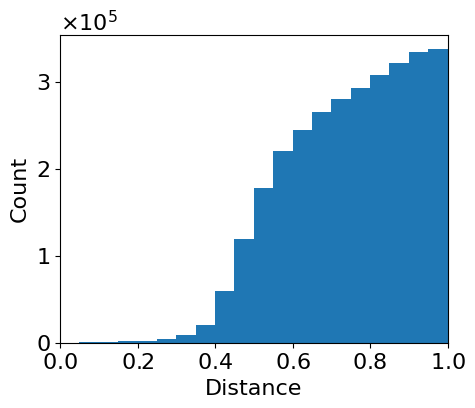

In [67]:
fig, ax = plt.subplots()
ax.bar((binedges[1:]+binedges[:-1])/2, hist, width=binedges[1])#, cumulative=True, density=True)
ax.set_xlim([0,1])
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
ax.set_xlabel('Distance')
ax.set_ylabel('Count')
fig.savefig(os.path.join(learning_dir, 'data_distance_hist.svg'))
fig.savefig(os.path.join(learning_dir, 'data_distance_hist.png'))

In [9]:
ts = torch.load(os.path.join(simulation_dir, 'Mcm_SDE_t_eval.pt'))
print(ts)

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 14

In [10]:
t_min = ts.min()
t_max = ts.max()

In [11]:
N_batch = x.shape[1]
N_t = x.shape[0]

In [12]:
N_particles = x.shape[2]

In [71]:
def plot_particles(n, t, flg_track=False):
    fig, ax = plt.subplots()
    
    ax.plot(x[t, n, ct[n]==0, 0], x[t, n, ct[n]==0, 1], 'k.')
    ax.plot(x[t, n, ct[n]==1, 0], x[t, n, ct[n]==1, 1], 'r.')
    ax.quiver(x[t, n, :, 0], x[t, n, :, 1], torch.cos(x[t, n, :, 2]), torch.sin(x[t, n, :, 2]))
    ax.grid(True)
    ax.set_aspect('equal')
    xy_mean = torch.mean(x[t, n, :, 0:2], dim=0)
    if flg_track:
        ax.set_xlim([xy_mean[0]-L/2, xy_mean[0]+L/2])
        ax.set_ylim([xy_mean[1]-L/2, xy_mean[1]+L/2])
    else:
        ax.set_xlim([0, L])
        ax.set_ylim([0, L])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('t = {:.1f}'.format(ts[t]))
    return fig, ax

In [72]:
@interact(n=(0, N_batch-1), t = (0, N_t-1))
def f(n, t):
    fig, ax = plot_particles(n,t)

interactive(children=(IntSlider(value=2, description='n', max=5), IntSlider(value=150, description='t', max=30…

In [13]:
def make_graph(t, ns):
    gs = [dgl.graph((torch.tensor([], dtype=int), torch.tensor([], dtype=int)), num_nodes=N_particles)] * len(ns)
    for n, g in zip(ns, gs):
        #g.add_nodes(N_particles)
        g.ndata['x'] = x[t, n, :, :2]
        g.ndata['theta'] = x[t, n, :, 2:]
        g.ndata['celltype'] = ct[n]
    gs = dgl.batch(gs)
    return gs

In [14]:
def pred_force_in_graph(g):
    learned_model.deleteGraph()
    learned_model.dynamicGNDEmodule.edgeRefresher.edgeConditionModule(g)
    g = learned_model.dynamicGNDEmodule.edgeRefresher.createEdge(g)
    g.ndata['p'] = learned_model.dynamicGNDEmodule.calc_module.polarity2vector(g.ndata['theta'])
    g.ndata['theta_mod'] = torch.remainder(g.ndata['theta'], 2*np.pi)
    g.apply_edges(learned_model.dynamicGNDEmodule.calc_module.calc_message)
    f2 = learned_model.dynamicGNDEmodule.calc_module.rot_tensor(g.edata['m_v'], g.ndata['theta_mod'][g.edges()[1]])
    g.ndata['emb3'] = learned_model.dynamicGNDEmodule.calc_module.embedding[learned_model.dynamicGNDEmodule.calc_module.i_embeddings['f3NN']](g.ndata['celltype'])
    g.ndata['emb4'] = learned_model.dynamicGNDEmodule.calc_module.embedding[learned_model.dynamicGNDEmodule.calc_module.i_embeddings['f4NN']](g.ndata['celltype'])
    g.ndata['v3'] = learned_model.dynamicGNDEmodule.calc_module.rot_tensor(learned_model.dynamicGNDEmodule.calc_module.f3NN(g.ndata['emb3']), g.ndata['theta_mod'])
    g.ndata['w4'] = learned_model.dynamicGNDEmodule.calc_module.f4NN(g.ndata['emb4'])
    return g.ndata['v3'].detach().reshape(-1, 2), f2.detach().reshape(-1, 2), g.ndata['w4'].detach().reshape(-1, 1), g.edata['m_t'].detach().reshape(-1, 1), torch.stack(g.edges(), dim=1).detach()

In [15]:
def true_force_in_graph(g):
    simulation_model.deleteGraph()
    simulation_model.dynamicGNDEmodule.edgeRefresher.edgeConditionModule(g)
    g = simulation_model.dynamicGNDEmodule.edgeRefresher.createEdge(g)
    g.apply_edges(simulation_model.dynamicGNDEmodule.calc_module.calc_message)
    g.ndata['p'] = simulation_model.dynamicGNDEmodule.calc_module.polarity2vector(g.ndata['theta'])
    g.ndata['v3'] = simulation_model.dynamicGNDEmodule.calc_module.u0 * g.ndata['p']
    g.ndata['w4'] = simulation_model.dynamicGNDEmodule.calc_module.A_ext * g.ndata['p'][..., :1]
    return g.ndata['v3'].detach().reshape(-1, 2), g.edata['m_v'].detach().reshape(-1, 2), g.ndata['w4'].detach().reshape(-1, 1), g.edata['m_t'].detach().reshape(-1, 1), torch.stack(g.edges(), dim=1).detach()

In [16]:
true_f1 = []
pred_f1 = []
true_f2 = []
pred_f2 = []
true_g1 = []
pred_g1 = []
true_g2 = []
pred_g2 = []
true_edges = []
pred_edges = []
N_minibatch = 50

learned_model.to(device)
simulation_model.to(device)


for t in trange(N_t):
  for n in range(0, N_batch, N_minibatch):
    ns = np.arange(n, min(n+N_minibatch, N_batch))
    g = make_graph(t, ns).to(device)
    tf1, tf2, tg1, tg2, tf_edges = true_force_in_graph(g)
    tf_nt = torch.zeros_like(tf_edges)
    tf_nt[..., 0] = t
    tf_nt[..., 1] = n
    tf_edges = torch.cat((tf_edges, tf_nt), dim=-1)
    true_f1.append(tf1.cpu())
    true_f2.append(tf2.cpu())
    true_g1.append(tg1.cpu())
    true_g2.append(tg2.cpu())
    true_edges.append(tf_edges.cpu())
    simulation_model.deleteGraph()
    #print(true_force)
    g = make_graph(t, ns).to(device)
    pf1, pf2, pg1, pg2, pf_edges = pred_force_in_graph(g)
    pf_nt = torch.zeros_like(pf_edges)
    pf_nt[..., 0] = t
    pf_nt[..., 1] = n
    pf_edges = torch.cat((pf_edges, pf_nt), dim=-1)
    pred_f1.append(pf1.cpu())
    pred_f2.append(pf2.cpu())
    pred_g1.append(pg1.cpu())
    pred_g2.append(pg2.cpu())
    pred_edges.append(pf_edges.cpu())
    #print(pred_force)
    learned_model.deleteGraph()
pred_f1 = torch.concat(pred_f1, dim=0)
true_f1 = torch.concat(true_f1, dim=0)
pred_f2 = torch.concat(pred_f2, dim=0)
true_f2 = torch.concat(true_f2, dim=0)
pred_g1 = torch.concat(pred_g1, dim=0)
true_g1 = torch.concat(true_g1, dim=0)
pred_g2 = torch.concat(pred_g2, dim=0)
true_g2 = torch.concat(true_g2, dim=0)
pred_edges = torch.concat(pred_edges, dim=0)
true_edges = torch.concat(true_edges, dim=0)


100%|█████████████████████████████████████████| 301/301 [00:33<00:00,  9.00it/s]


In [17]:
if true_edges.shape[0] != pred_edges.shape[0]:
    flg_diffedge = True
else: 
    flg_diffedge = (torch.sort(true_edges, dim=0)[0] != torch.sort(pred_edges, dim=0)[0]).any()

print(flg_diffedge)

if flg_diffedge:
    true_pred_edges, i_true_pred, n_true_pred = torch.unique(torch.cat([true_edges, pred_edges], dim=0), sorted=False, return_inverse=True, return_counts=True, dim=0)
    edges_only_true = n_true_pred == 1 and i_true_pred < true_edges.shape[0]
    edges_only_pred = n_true_pred == 1 and i_true_pred >= true_edges.shape[0]
    edges_both = n_true_pred == 2
    true_f1_all = torch.zeros([true_pred_edges.shape[0], 2], dtype=true_f1.dtype, device=true_f1.device)
    pred_f1_all = torch.zeros([true_pred_edges.shape[0], 2], dtype=pred_f1.dtype, device=pred_f1.device)
    true_f1_all[i_true_pred[edges_only_true]] = true_f1
    pred_f1_all[i_true_pred[edges_only_pred]] = pred_f1
    true_f1_all[i_true_pred[edges_both]] = true_f1
    pred_f1_all[i_true_pred[edges_both]] = pred_f1
    true_f2_all = torch.zeros([true_pred_edges.shape[0], 2], dtype=true_f2.dtype, device=true_f2.device)
    pred_f2_all = torch.zeros([true_pred_edges.shape[0], 2], dtype=pred_f2.dtype, device=pred_f2.device)
    true_f2_all[i_true_pred[edges_only_true]] = true_f2
    pred_f2_all[i_true_pred[edges_only_pred]] = pred_f2
    true_f2_all[i_true_pred[edges_both]] = true_f2
    pred_f2_all[i_true_pred[edges_both]] = pred_f2
else:
    true_f1_all = true_f1
    pred_f1_all = pred_f1
    true_f2_all = true_f2
    pred_f2_all = pred_f2

tensor(False)


In [18]:
def calc_MSE_MAE(true, pred):
    mse = ((true - pred)**2).sum(dim=-1).mean()
    mae = torch.abs(true - pred).sum(dim=-1).mean()
    return mse, mae

In [19]:
def calc_normalized_MSE_MAE(true_force, pred_force):
    norm_force = torch.norm(true_force, dim=-1, keepdim=True)
    error_force = pred_force - true_force
    norm_error = torch.norm(error_force, dim=-1, keepdim=True)
    normalized_MSE = (norm_error**2).mean() / (norm_force**2).mean()
    normalized_MAE = abs(error_force).mean() / abs(true_force).mean()
    return normalized_MSE, normalized_MAE

In [20]:
normalized_MSE_f1, normalized_MAE_f1 = calc_normalized_MSE_MAE(true_f1_all, pred_f1_all)
normalized_MSE_f1, normalized_MAE_f1

(tensor(0.0064), tensor(0.0801))

In [21]:
normalized_MSE_f2, normalized_MAE_f2 = calc_normalized_MSE_MAE(true_f2_all, pred_f2_all)
normalized_MSE_f2, normalized_MAE_f2

(tensor(0.3897), tensor(0.2283))

In [22]:
normalized_MSE_g2, normalized_MAE_g2 = calc_normalized_MSE_MAE(true_g2, pred_g2)
normalized_MSE_g2, normalized_MAE_g2

(tensor(0.1380), tensor(0.1985))

In [23]:
MSE_g1, MAE_g1 = calc_MSE_MAE(true_g1, pred_g1)
MSE_g1, MAE_g1

(tensor(3.1464e-05), tensor(0.0054))

In [24]:
error_data = {'normalizedMSE_f1': normalized_MSE_f1.item(), 'normalizedMAE_f1': normalized_MAE_f1.item(), 
              'normalizedMSE_f2': normalized_MSE_f2.item(), 'normalizedMAE_f2': normalized_MAE_f2.item(), 
              'normalizedMSE_g2': normalized_MSE_g2.item(), 'normalizedMAE_g2': normalized_MAE_g2.item(), 
              'MSE_g1': MSE_g1.item(), 'MAE_g1': MAE_g1.item()}

In [25]:
np.save(os.path.join(learning_dir, 'pred_error_in_dataset.npy'),
        error_data)

In [26]:
with open(os.path.join(learning_dir, 'pred_error_in_dataset.csv'),'w',encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = error_data.keys())
    writer.writeheader()
    writer.writerows([error_data])